# Financial News Sentiment Analysis

1. Multinomial Naive Bayes
2. Logisitic Regression
3. SVM
4. Deep Learning (LSTMs)
5. BERT

## Import libraries

In [66]:
!pip install simpletransformers

     |████████████████████████████████| 215 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 43 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 7.3 MB/s eta 0:00:01    |█▏                              | 102 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.4 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 939 kB/s eta 0:00:01
     |████████████████████████████████| 308 kB 661 kB/s eta 0:00:01
     |████████████████████████████████| 721 kB 177 kB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 159 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 17.7 MB 4.

  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=1cff4ef624a7f7960bf7aaf705a732fe24f07269e5880a122e57464a53d5c1c3
  Stored in directory: /home/crispy/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=75947fc2c080cf57036240a14575c64f1ec52a7858e868f80d942baac0b508f6
  Stored in directory: /home/crispy/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0


  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6489 sha256=e54378da9e3e00eacba37f14e2b54aa0bce64ad455a029ba919060b9babcdcc3
  Stored in directory: /home/crispy/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21495 sha256=f2a8ab822fba4ba16d792aa68da09e3b4f38e62e1a475451e79e7c3d23400d55
  Stored in directory: /home/crispy/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built seqeval sacremoses subprocess32 promise
ERROR: fastai 1.0.61 requires torch>=1.0.0, which is not installed.
ERROR: fastai 1.0.61 requires torchvision, which is not installed.
ERROR: transformers 3.4.0 has requirement tokenizers==0.9.2, but you'll have tokenizers 0.9.3 which is incompatible.
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.42.1
    Uninstalling tqdm-4.42.1:
      Successfully uninstalled tqdm-4.42.1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding

from simpletransformers.classification import ClassificationModel, ClassificationArgs

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2500)])
  except RuntimeError as e:
    print(e)

## Load the data

In [3]:
df = pd.read_csv('all-data.csv',encoding='ISO-8859-1',header=None,names=['Target','News'])
df.drop_duplicates(subset=['News'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  4838 non-null   object
 1   News    4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [4]:
X,y = df['News'], df['Target']

In [5]:
for i in np.random.randint(X.shape[0],size=10):
    print(f'News Item {i}: {X[i]}')
    print(f'Sentiment: {y[i]}')
    print('\n')

News Item 2964: In volume , the focus is already outside Finland , as 60 % of the group 's products are made in Poland and the Baltic countries .
Sentiment: neutral


News Item 4033: Operating loss of the Pulp & Paper Machinery unit was over EUR 3mn in September 2007 - August 2008 , compared to a profit of EUR 3.7 mn a year earlier .
Sentiment: negative


News Item 4750: Operating profit in the fourth quarter fell to EUR33m from EUR39m a year earlier .
Sentiment: negative


News Item 1502: At a press conference , Lattelecom board chairman Nils Melngailis explained that Blackstone had been chosen for its experience in the IT sector as well as its financial strength .
Sentiment: positive


News Item 845: Hearst will be able to consolidate about 20 % of all Russian market for advertising in press after the purchase .
Sentiment: positive


News Item 2748: Finnish power company Fortum reports 89 % of its electricity was generated without carbon dioxide emissions in 2007 .
Sentiment: neutral

One can see that the data has been preprocessed to an extent such 

In [6]:
print(f'Number of headlines: {X.shape[0]}')

Number of headlines: 4838


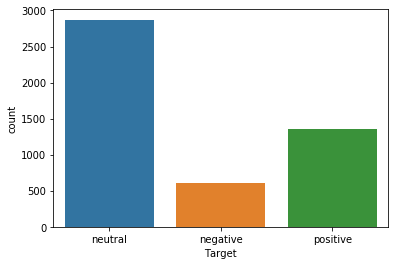

In [7]:
sns.countplot(y)
plt.show()

In [8]:
y.value_counts()

neutral     2872
positive    1362
negative     604
Name: Target, dtype: int64

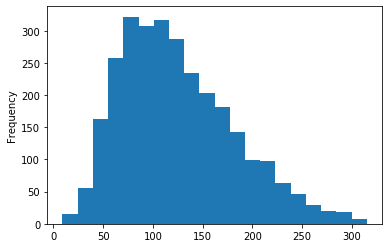

In [9]:
X[y=='neutral'].apply(len).plot.hist(bins=20)
plt.show()

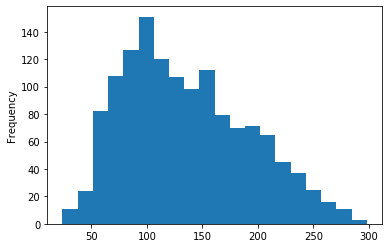

In [10]:
X[y=='positive'].apply(len).plot.hist(bins=20)
plt.show()

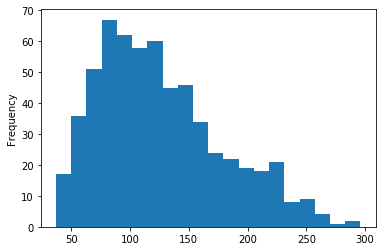

In [11]:
X[y=='negative'].apply(len).plot.hist(bins=20)
plt.show()

In [12]:
target_dict = {'neutral':0, 'negative':1,'positive':2}
y = y.map(target_dict)

In [13]:
y.value_counts()

0    2872
2    1362
1     604
Name: Target, dtype: int64

### Split the Dataset

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=0)

## Models without preprocessing

**Bag of Words Model to preprocess text into a suitable form**

In [220]:
count_vec = CountVectorizer(max_features=8000, ngram_range=(1,2))
tfidf = TfidfTransformer()

In [221]:
X_train_features = count_vec.fit_transform(X_train)
X_test_features = count_vec.transform(X_test)

X_train_features = tfidf.fit_transform(X_train_features)
X_test_features = tfidf.transform(X_test_features)

In [222]:
X_train_features.shape

(3870, 8000)

### Multinomial Naive Bayes

In [223]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_features, y_train)

y_pred_train = nb_clf.predict(X_train_features)
y_pred_test = nb_clf.predict(X_test_features)

In [224]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 77.95865633074935
Test Accuracy: 71.28099173553719


In [225]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       575
           1       0.85      0.14      0.24       121
           2       0.71      0.40      0.52       272

    accuracy                           0.71       968
   macro avg       0.76      0.51      0.53       968
weighted avg       0.73      0.71      0.66       968



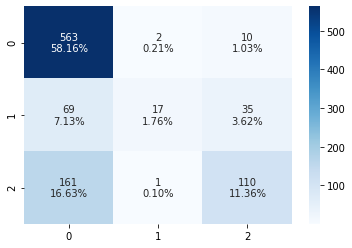

In [226]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Logistic Regression

In [100]:
lr = LogisticRegression()

lr.fit(X_train_features, y_train)

y_pred_train = lr.predict(X_train_features)
y_pred_test = lr.predict(X_test_features)

In [101]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 88.21705426356588
Test Accuracy: 77.37603305785123


In [102]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       575
           1       0.90      0.51      0.65       121
           2       0.79      0.52      0.63       272

    accuracy                           0.77       968
   macro avg       0.82      0.66      0.71       968
weighted avg       0.78      0.77      0.76       968



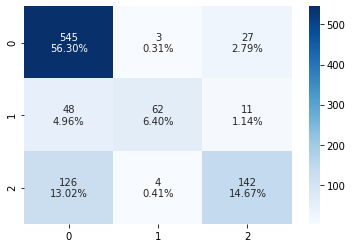

In [103]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Support Vector Machine

In [104]:
svc = SVC()

svc.fit(X_train_features, y_train)

y_pred_train = svc.predict(X_train_features)
y_pred_test = svc.predict(X_test_features)

In [105]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 96.74418604651163
Test Accuracy: 76.03305785123968


In [106]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.97      0.83       575
           1       0.93      0.46      0.62       121
           2       0.82      0.46      0.59       272

    accuracy                           0.76       968
   macro avg       0.83      0.63      0.68       968
weighted avg       0.78      0.76      0.74       968



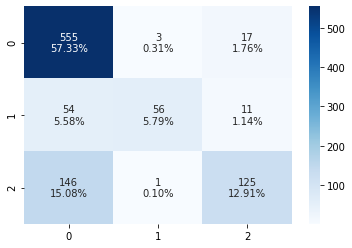

In [107]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Neural Network

In [131]:
# Number of unique words to include 
VOCAB_SIZE = 9000

# Length of each sentence. Sentences shorter than this will be padded and sentences longer will be truncated
MAX_LENGTH = 300

# Define the Out of Vocabulary character
OOV_TOK = '<UNK>'

In [132]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK, filters='!"#$&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)

In [133]:
word_index = tokenizer.word_index

In [134]:
X_sequences_train = tokenizer.texts_to_sequences(X_train)
X_sequences_test = tokenizer.texts_to_sequences(X_test)

In [135]:
X_NN_train = pad_sequences(X_sequences_train, maxlen=MAX_LENGTH, padding='post',truncating='pre')
X_NN_test = pad_sequences(X_sequences_test, maxlen=MAX_LENGTH, padding='post',truncating='pre')

In [136]:
X_NN_train.shape

(3870, 300)

In [137]:
EMBEDDING_DIM = 128

In [138]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

In [139]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 128)          1152000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 300, 128)          98816     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 1,296,387
Trainable params: 1,296,387
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [141]:
model.fit(X_NN_train, y_train, batch_size=64, epochs=20, validation_data=(X_NN_test, y_test))

Epoch 1/20
61/61 [==============================] - 6s 92ms/step - loss: 0.8752 - accuracy: 0.6220 - val_loss: 0.7523 - val_accuracy: 0.6581
Epoch 2/20
61/61 [==============================] - 2s 35ms/step - loss: 0.4873 - accuracy: 0.7987 - val_loss: 0.7317 - val_accuracy: 0.7097
Epoch 3/20
61/61 [==============================] - 2s 35ms/step - loss: 0.1827 - accuracy: 0.9424 - val_loss: 1.0165 - val_accuracy: 0.6798
Epoch 4/20
61/61 [==============================] - 2s 36ms/step - loss: 0.0857 - accuracy: 0.9749 - val_loss: 1.1881 - val_accuracy: 0.6890
Epoch 5/20
61/61 [==============================] - 2s 35ms/step - loss: 0.0460 - accuracy: 0.9858 - val_loss: 1.1879 - val_accuracy: 0.6994
Epoch 6/20
61/61 [==============================] - 2s 35ms/step - loss: 0.0310 - accuracy: 0.9910 - val_loss: 1.4527 - val_accuracy: 0.6746
Epoch 7/20
61/61 [==============================] - 2s 36ms/step - loss: 0.0240 - accuracy: 0.9943 - val_loss: 1.4963 - val_accuracy: 0.6798
Epoch 8/20
61

### BERT

In [36]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2
model_args.gradient_accumulation_steps = 8
model_args.learning_rate = 3e-5
model_args.num_train_epochs = 1
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True

model = ClassificationModel('bert', 'bert-base-cased', 
                            num_labels=3, 
                            args=model_args,
                            use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [37]:
train_df = pd.DataFrame({"Message":X_train,"Label":y_train})

model.train_model(train_df)

/home/crispy/anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:353: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/home/crispy/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(241, 0.6888989138985014)

In [38]:
train_result, train_model_outputs, train_wrong_predictions = model.eval_model(train_df)

/home/crispy/anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [39]:
eval_df = pd.DataFrame({"Message":X_test,"Label":y_test})
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [40]:
train_pred = []
for arr in train_model_outputs:
    train_pred.append(np.argmax(arr))

test_pred = []
for arr in model_outputs:
    test_pred.append(np.argmax(arr))

In [41]:
print("Training Accuracy:",accuracy_score(y_train,train_pred)*100)
print("Test Accuracy:",accuracy_score(y_test,test_pred)*100)

Training Accuracy: 83.66925064599484
Test Accuracy: 78.61570247933885


In [42]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       575
           1       0.61      0.78      0.68       121
           2       0.77      0.56      0.65       272

    accuracy                           0.79       968
   macro avg       0.74      0.74      0.73       968
weighted avg       0.79      0.79      0.78       968



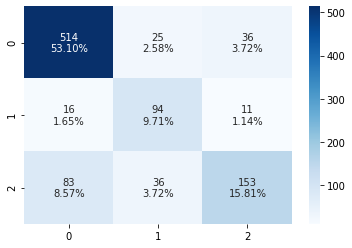

In [43]:
cm = confusion_matrix(y_test, test_pred)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

## Models with preprocessing

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/crispy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/crispy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/crispy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/crispy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation

In [16]:
stop = set(stopwords.words('english'))
stop.update(punctuation)
stop.discard('%')
print(stop)

{'himself', 'him', 'ma', 'how', 'they', 'll', 'mustn', 'because', 'ain', 'won', '/', 'or', '}', 'while', 'any', 'for', "couldn't", '?', "that'll", 'itself', 'the', "didn't", 'we', "shouldn't", '|', 'this', "aren't", 'his', 'what', 'after', 'an', 'here', 'should', 'o', 'can', 'yourself', 'their', ';', 'wouldn', '`', '_', 'myself', "mightn't", '~', 'each', "don't", "should've", 'those', '-', 'up', 'all', 'yours', 'have', 'down', 'couldn', 'hers', 'you', "hasn't", 'such', "shan't", '!', 'more', 'other', 'do', 'me', 'both', 've', 'be', 'then', 'does', ')', 'am', "it's", 'about', 'through', 'some', 'my', 'shan', '<', 'y', ',', 'so', '{', 'during', 'on', 'd', 'now', 'to', 'he', 'and', 'm', 'only', 'was', 'whom', '*', 'doesn', "weren't", 'with', '$', "needn't", 'is', "you'll", 'themselves', 'isn', '+', "'", '.', 'hadn', 'between', 'herself', 'why', 'needn', 'if', '[', "you're", "wouldn't", "doesn't", "you'd", "mustn't", 'being', 'once', 'i', 'until', 'at', "isn't", 'when', 'there', 'further',

In [17]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
lemmatizer = WordNetLemmatizer()
def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)

In [19]:
X_normalized = X.apply(clean_review)
X_normalized = X_normalized.apply(join_text)

### View the normalized and cleaned data

In [20]:
for i in np.random.randint(X_normalized.shape[0],size=10):
    print(f'News Item {i}: {X_normalized[i]}')
    print(f'Sentiment: {y[i]}')
    print('\n')

News Item 3188: company expect meat purchase remain 8mn kilo 2011
Sentiment: 0


News Item 3950: could u time `` say
Sentiment: 0


News Item 624: testament quality LTE solution commitment Japanese market add
Sentiment: 0


News Item 4455: stable outlook reflect Nokia 's strong market position global mobile handset market strong cash flow generation conservative balance sheet say Raab
Sentiment: 2


News Item 4475: Creating interface similar interaction real world enable experience natural intuitive way modern game movie immersive use realistic 3-D graphic
Sentiment: 0


News Item 1705: Net sale Finnish Sanoma Learning Literature Finnish medium group Sanoma decrease 3.6 % January-June 2009 total EUR 162.8 mn EUR 168.8 mn correspond period 2008
Sentiment: 1


News Item 4197: resignation take effect immediately
Sentiment: 0


News Item 1439: product include Personal Communications product mobile phone part Home Communications product set-top box electronics flat panel TVs well Communicat

### Split the dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized,y,test_size=0.2,stratify=y, random_state=0)

**Bag of Words Model to preprocess text into a suitable form**

In [234]:
count_vec = CountVectorizer(max_features=8000, ngram_range=(1,2))
tfidf = TfidfTransformer()

In [235]:
X_train_features = count_vec.fit_transform(X_train)
X_test_features = count_vec.transform(X_test)

X_train_features = tfidf.fit_transform(X_train_features)
X_test_features = tfidf.transform(X_test_features)

In [236]:
X_train_features.shape

(3870, 8000)

### Multinomial Naive Bayes

In [237]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_features, y_train)

y_pred_train = nb_clf.predict(X_train_features)
y_pred_test = nb_clf.predict(X_test_features)

In [238]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 76.5374677002584
Test Accuracy: 69.93801652892562


In [239]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.70      0.97      0.82       575
           1       0.86      0.16      0.27       121
           2       0.65      0.36      0.46       272

    accuracy                           0.70       968
   macro avg       0.74      0.50      0.52       968
weighted avg       0.71      0.70      0.65       968



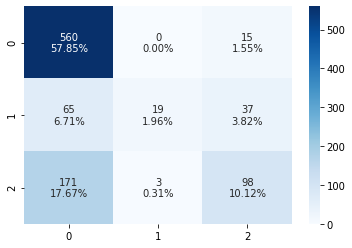

In [240]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Logisitic Regression

In [241]:
lr = LogisticRegression()

lr.fit(X_train_features, y_train)

y_pred_train = lr.predict(X_train_features)
y_pred_test = lr.predict(X_test_features)

In [242]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 86.95090439276485
Test Accuracy: 73.24380165289256


In [243]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       575
           1       0.65      0.36      0.46       121
           2       0.71      0.48      0.57       272

    accuracy                           0.73       968
   macro avg       0.70      0.59      0.62       968
weighted avg       0.72      0.73      0.71       968



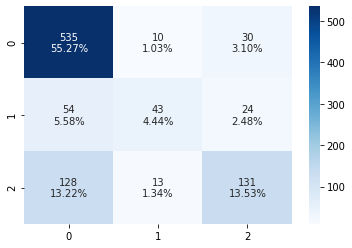

In [244]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Support Vector Machines

In [245]:
svc = SVC()

svc.fit(X_train_features, y_train)

y_pred_train = svc.predict(X_train_features)
y_pred_test = svc.predict(X_test_features)

In [246]:
print("Training Accuracy:",accuracy_score(y_train,y_pred_train)*100)
print("Test Accuracy:",accuracy_score(y_test,y_pred_test)*100)

Training Accuracy: 97.13178294573643
Test Accuracy: 72.31404958677686


In [247]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       575
           1       0.66      0.29      0.40       121
           2       0.75      0.40      0.53       272

    accuracy                           0.72       968
   macro avg       0.71      0.55      0.58       968
weighted avg       0.72      0.72      0.69       968



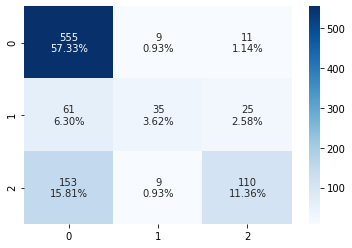

In [248]:
cm = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Neural Network

In [22]:
# Number of unique words to include 
VOCAB_SIZE = 9000

# Length of each sentence. Sentences shorter than this will be padded and sentences longer will be truncated
MAX_LENGTH = 300

# Define the Out of Vocabulary character
OOV_TOK = '<UNK>'

In [23]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK, filters='!"#$&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)

In [24]:
word_index = tokenizer.word_index

In [25]:
X_sequences_train = tokenizer.texts_to_sequences(X_train)
X_sequences_test = tokenizer.texts_to_sequences(X_test)

In [26]:
X_NN_train = pad_sequences(X_sequences_train, maxlen=MAX_LENGTH, padding='post',truncating='pre')
X_NN_test = pad_sequences(X_sequences_test, maxlen=MAX_LENGTH, padding='post',truncating='pre')

In [27]:
X_NN_train.shape

(3870, 300)

In [28]:
EMBEDDING_DIM = 128

In [29]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1152000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,296,387
Trainable params: 1,296,387
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [32]:
model.fit(X_NN_train, y_train, batch_size=64, epochs=20, validation_data=(X_NN_test, y_test))

Epoch 1/20
61/61 [==============================] - 5s 79ms/step - loss: 0.8927 - accuracy: 0.6137 - val_loss: 0.7539 - val_accuracy: 0.6694
Epoch 2/20
61/61 [==============================] - 2s 33ms/step - loss: 0.5462 - accuracy: 0.7576 - val_loss: 0.6644 - val_accuracy: 0.7221
Epoch 3/20
61/61 [==============================] - 2s 33ms/step - loss: 0.2530 - accuracy: 0.9106 - val_loss: 0.7701 - val_accuracy: 0.7355
Epoch 4/20
61/61 [==============================] - 2s 34ms/step - loss: 0.1275 - accuracy: 0.9636 - val_loss: 0.9774 - val_accuracy: 0.7438
Epoch 5/20
61/61 [==============================] - 2s 34ms/step - loss: 0.0737 - accuracy: 0.9786 - val_loss: 1.1028 - val_accuracy: 0.7169
Epoch 6/20
61/61 [==============================] - 2s 34ms/step - loss: 0.0560 - accuracy: 0.9842 - val_loss: 1.1433 - val_accuracy: 0.7283
Epoch 7/20
61/61 [==============================] - 2s 34ms/step - loss: 0.0396 - accuracy: 0.9904 - val_loss: 1.3666 - val_accuracy: 0.7345
Epoch 8/20
61

### BERT

In [22]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2
model_args.gradient_accumulation_steps = 8
model_args.learning_rate = 3e-5
model_args.num_train_epochs = 1
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True

model = ClassificationModel('bert', 'bert-base-cased', 
                            num_labels=3, 
                            args=model_args,
                            use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
train_df = pd.DataFrame({"Message":X_train,"Label":y_train})

model.train_model(train_df)

In [ ]:
train_result, train_model_outputs, train_wrong_predictions = model.eval_model(train_df)

In [ ]:
eval_df = pd.DataFrame({"Message":X_test,"Label":y_test})
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [ ]:
train_pred = []
for arr in train_model_outputs:
    train_pred.append(np.argmax(arr))

test_pred = []
for arr in model_outputs:
    test_pred.append(np.argmax(arr))

In [ ]:
print("Training Accuracy:",accuracy_score(y_train,train_pred)*100)
print("Test Accuracy:",accuracy_score(y_test,test_pred)*100)

In [ ]:
print(classification_report(y_test, test_pred))

In [ ]:
cm = confusion_matrix(y_test, test_pred)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()